In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from utility import analysis_parameters as ap
import numpy as np
import dask
# from dask.diagnostics import ProgressBar
# pbar = ProgressBar()
# pbar.register()

model="SHiELD"
region='TWP'
chunk_dict = {"lat":100, "lon":100, "latitude":100, "longitude":100, "Xdim":2400}
plt.rcParams["font.size"]=14
colors = ap.COLORS

In [2]:
# plt.rcParams

## Histogram of OLR and IWP in TWP region for each model

In [3]:
model="SHiELD"
# load iwp and olr
iwp = ap.load_iwp(model, region, total=True, chunks=chunk_dict)
olr = ap.load_olr(model, region, r=0)
print(iwp.shape, olr.shape)
olr

returned ice + snow + graupel SHiELD TWP
(2880, 110626) (2880, 110626)


<xarray.DataArray 'rlut' (time: 2880, Xdim: 110626)>
dask.array<open_dataset-7fcce5ee754525c4c5afc70bb3dec23erlut, shape=(2880, 110626), dtype=float32, chunksize=(500, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30T00:15:00 ... 2020-02-29
    lon      (Xdim) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat      (Xdim) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
Dimensions without coordinates: Xdim
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      top of atmos upward longwave flux [W/m**2]
    units:          W m-2
    CDI_grid_type:  unstructured
    cell_methods:   time: point

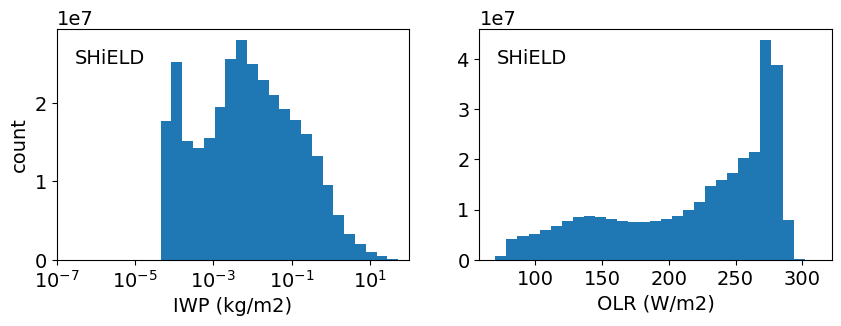

In [18]:
# calculate histograms & plot!
fig, ax = plt.subplots(1,2,figsize=(10,3))
iwp.plot.hist(bins=np.logspace(-6,2,30), ax=ax[0])
olr.plot.hist(bins=np.linspace(70,310,30), ax=ax[1])
ax[0].set(xlabel="IWP (kg/m2)", ylabel="count", xscale="log", xlim=[1e-7,1e2])
ax[1].set(xlabel="OLR (W/m2)", ylabel="")
ax[0].annotate(model, xy=(0.05,0.85), xycoords="axes fraction")
ax[1].annotate(model, xy=(0.05,0.85), xycoords="axes fraction")
plt.savefig("../plots/TWP/TWP_hist_iwp_olr_{}_count.png".format(model), 
            dpi=150, bbox_inches="tight", pad_inches=0.2)
plt.show()

## vertical profiles of cloud fraction and IWC

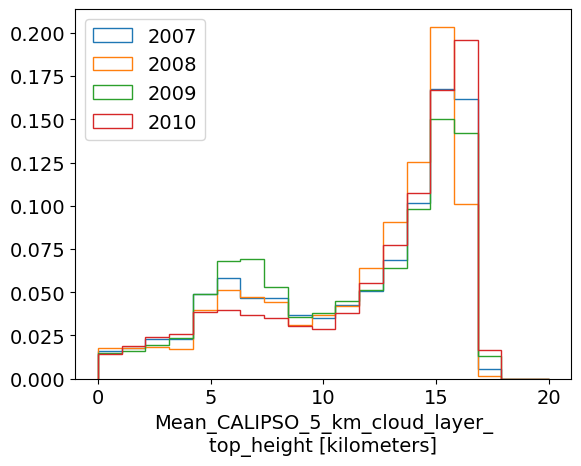

In [38]:
# add in observations - CCCM
ds = xr.open_dataset("/work/bb1153/b380883/TWP/CERES_CCCM_JAS_2007-2011.nc")
ds = ds["Mean_CALIPSO_5_km_cloud_layer_top_height"].groupby(ds.time.dt.year)
fig, ax = plt.subplots(1,1)
ds[2007].plot.hist(bins=np.linspace(0,20,20), density=1, histtype="step", ax=ax, label="2007")
ds[2008].plot.hist(bins=np.linspace(0,20,20), density=1, histtype="step", ax=ax, label="2008")
ds[2009].plot.hist(bins=np.linspace(0,20,20), density=1, histtype="step", ax=ax, label="2009")
ds[2010].plot.hist(bins=np.linspace(0,20,20), density=1, histtype="step", ax=ax, label="2010")
plt.legend(loc=2)
plt.show()
# plot.hist(bins=np.arange(0,21,1))
# ds["Cloud fraction (CALIPSO-CloudSat)"].groupby(ds.time.dt.year).mean()

# cltotal_dict["CCCM_DY2"] = (ds["iwc used in CERES radiation, avg over cloudy part of CERES footprint"]+\
#                         ds["lwc used in CERES radiation, avg over cloudy part of CERES footprint"]).mean(axis=0)/1000
# models2=["CCCM_DY2"]+models2
# z_dict["CCCM_DY2"] = ds.alt*1000
# print("CCCM_DY2", cltotal_dict["CCCM_DY2"].shape, cl_dict["CCCM_DY2"].shape, z_dict["CCCM_DY2"].shape)
# print("... done observations DY2")

In [3]:
models2=["SHiELD", "ICON", "SAM", "UM", "ARP", "SCREAM"]
models1=["FV3", "SAM"]
var="cl_5e-7kgm-3"
var2 = "totalwater"
var1 = "iwc"
varz = "cldfrac_z"

# load cld frac and iwc profiles into dicts
cltotal_dict = {}
cl_dict = {}
z_dict = {}

# add in the models from DY2
for m in models2:
    print(m, "DY2")
    if (m=="SAM") or (m=="UM"):  # latlon models
        axtup = (0,2,3)
        axtup2 = axtup
    else:
        axtup = (0,2)
        axtup2 = axtup
    ## get total frozen hydrometeors & cloud fraction
    cltotal_dict[m+"_DY2"] = xr.open_dataset(ap.get_fldmean_file(m, region, var2))[var2].mean(axis=axtup)
    cl_dict[m+"_DY2"] = xr.open_dataset(ap.get_fldmean_file(m, region, var)).cl.mean(axis=axtup2)
    if (m=="SCREAM") or (m=="ICON") or (m=="ARP") or (m=="UM"):
        cltotal_dict[m+"_DY2"] = cltotal_dict[m+"_DY2"][1:]
        cl_dict[m+"_DY2"] = cl_dict[m+"_DY2"][1:]
    ## get height variables
    if m=="SAM":
        z_dict["SAM_DY2"] = cl_dict["SAM_DY2"].z.rename({"z":"zg"})
        cltotal_dict["SAM_DY2"] = cltotal_dict["SAM_DY2"]/1000
    else:
        z_dict[m+"_DY2"] = xr.open_dataset(ap.get_xytmean_file(m,"TWP","zg")).zg
    print(m+"_DY2", cltotal_dict[m+"_DY2"].shape, cl_dict[m+"_DY2"].shape, z_dict[m+"_DY2"].shape)
print("... done DY2.")

# add in the models from DY1
for m in models1:
    print(m, "DY1")
    axtup = (0,2)
    ## get total frozen hydrometeors & cloud fraction
    if m[:3]=="NIC":
        var1="twc"
    if m[:3]=="ICO":
        cltotal_dict[m+"_DY1"] = xr.open_dataset(ap.DY1+"TWP/TWP_{}_twc_profile_20160810-20160910.nc".format(m))[var1][0,:,0]
        cl_dict[m+"_DY1"] = xr.open_dataset(ap.DY1+"TWP/TWP_{}_cldfrac_profile_20160810-20160910.nc".format(m)).cldfrac[0,:,0]
    else:
        cltotal_dict[m+"_DY1"] = xr.open_dataset(ap.DY1+"TWP/TWP_{}_twc_profile_20160810-20160910.nc".format(m))[var1][0,:,0,0]
        cl_dict[m+"_DY1"] = xr.open_dataset(ap.DY1+"TWP/TWP_{}_cldfrac_profile_20160810-20160910.nc".format(m)).cldfrac[0,:,0,0]
    # cl_dict[m+"_DY1"] = xr.open_dataset(ap.get_fldmean_file(m, region, var)).cl.mean(axis=axtup2)
    # if (m=="ICON") or (m=="ARP") or (m=="UM"):
    #     cltotal_dict[m+"_DY1"] = cltotal_dict[m+"_DY1"][1:]
    #     cl_dict[m+"_DY1"] = cl_dict[m+"_DY1"][1:]
    ## get height variables
    if m[:3]=="FV3":
        z_dict[m+"_DY1"] = z_dict["SHiELD_DY2"]
    else:
        z_dict[m+"_DY1"] = cltotal_dict[m+"_DY1"].lev
    print(m+"_DY1", cltotal_dict[m+"_DY1"].shape, cl_dict[m+"_DY1"].shape, z_dict[m+"_DY1"].shape)
    var1="iwc"
print("... done DY1.")

######## DY2 ########
# add in observations - DARDAR
ds = xr.open_dataset("/work/bb1153/b380883/TWP/twp.nc")
cltotal_dict["DARDAR_DY2"] = ds.iwc.mean(axis=0)/1000
cl_dict["DARDAR_DY2"] = np.where(ds.iwc>5e-4,1,0).mean(axis=0)
models2=["DARDAR_DY2"]+models2
z_dict["DARDAR_DY2"] = ds.height
print("DARDAR_DY2", cltotal_dict["DARDAR_DY2"].shape, cl_dict["DARDAR_DY2"].shape, z_dict["DARDAR_DY2"].shape)

# add in observations - CCCM
ds = xr.open_dataset("/work/bb1153/b380883/TWP/CCCM_dTWP_2007-2010.nc")
cl_dict["CCCM_DY2"] = ds["Cloud fraction (CALIPSO-CloudSat)"].mean(axis=0)
cltotal_dict["CCCM_DY2"] = (ds["iwc used in CERES radiation, avg over cloudy part of CERES footprint"]+\
                        ds["lwc used in CERES radiation, avg over cloudy part of CERES footprint"]).mean(axis=0)/1000
models2=["CCCM_DY2"]+models2
z_dict["CCCM_DY2"] = ds.alt*1000
print("CCCM_DY2", cltotal_dict["CCCM_DY2"].shape, cl_dict["CCCM_DY2"].shape, z_dict["CCCM_DY2"].shape)
print("... done observations DY2")

# # DY1
# # add in observations - DARDAR
# ds = xr.open_dataset("/work/bb1153/b380883/TWP/twp.nc")
# cltotal_dict["DARDAR_DY2"] = ds.iwc.mean(axis=0)/1000
# cl_dict["DARDAR_DY2"] = np.where(ds.iwc>5e-4,1,0).mean(axis=0)
# models=["DARDAR_DY2"]+models2
# z_dict["DARDAR_DY2"] = ds.height
# print("DARDAR_DY2", cltotal_dict["DARDAR_DY2"].shape, cl_dict["DARDAR_DY2"].shape, z_dict["DARDAR_DY2"].shape)
# # add in observations - CCCM
# ds = xr.open_dataset("/work/bb1153/b380883/TWP/CCCM_dTWP_2007-2010.nc")
# cl_dict["CCCM_DY2"] = ds["Cloud fraction (CALIPSO-CloudSat)"].mean(axis=0)
# cltotal_dict["CCCM_DY2"] = (ds["iwc used in CERES radiation, avg over cloudy part of CERES footprint"]+\
#                         ds["lwc used in CERES radiation, avg over cloudy part of CERES footprint"]).mean(axis=0)/1000
# models=["CCCM_DY2"]+models2
# z_dict["CCCM_DY2"] = ds.alt*1000
# print("CCCM_DY2", cltotal_dict["CCCM_DY2"].shape, cl_dict["CCCM_DY2"].shape, z_dict["CCCM_DY2"].shape)

print("...done")

SHiELD DY2
SHiELD_DY2 (79,) (79,) (79,)
ICON DY2
ICON_DY2 (76,) (76,) (76,)
SAM DY2
SAM_DY2 (61,) (61,) (61,)
UM DY2
UM_DY2 (54,) (54,) (54,)
ARP DY2
ARP_DY2 (59,) (59,) (59,)
SCREAM DY2
SCREAM_DY2 (127,) (127,) (127,)
... done DY2.
FV3 DY1
FV3_DY1 (79,) (79,) (79,)
SAM DY1
SAM_DY1 (74,) (74,) (74,)
... done DY1.
DARDAR_DY2 (436,) (436,) (436,)
CCCM_DY2 (92,) (92,) (92,)
... done observations DY2
...done


In [4]:
cl_dict.keys(), cltotal_dict.keys()

(dict_keys(['SHiELD_DY2', 'ICON_DY2', 'SAM_DY2', 'UM_DY2', 'ARP_DY2', 'SCREAM_DY2', 'FV3_DY1', 'SAM_DY1', 'DARDAR_DY2', 'CCCM_DY2']),
 dict_keys(['SHiELD_DY2', 'ICON_DY2', 'SAM_DY2', 'UM_DY2', 'ARP_DY2', 'SCREAM_DY2', 'FV3_DY1', 'SAM_DY1', 'DARDAR_DY2', 'CCCM_DY2']))

DARDAR_DY2
CCCM_DY2
ICON_DY2
SAM_DY1
SAM_DY2
FV3_DY1
SHiELD_DY2
ARP_DY2
UM_DY2


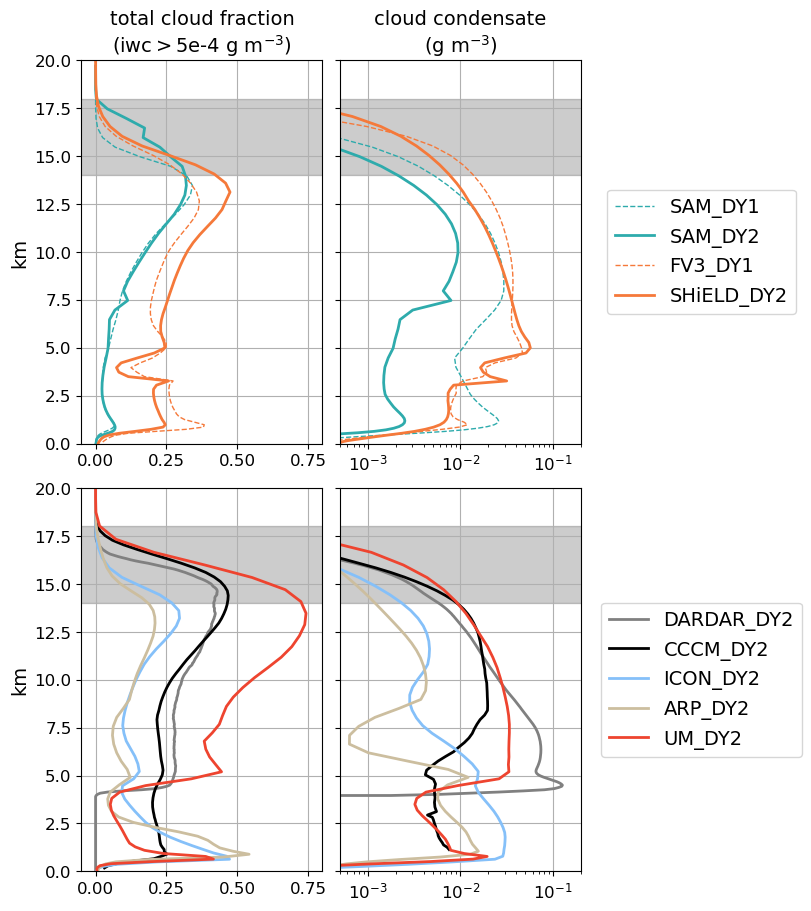

In [6]:
fig, [[ax, axt],[axb, axbt]] = plt.subplots(2,2, figsize=(8,9), constrained_layout=True, sharey=True)
emph="CCCM" # specific which model to emphasize by making the line thicker
models_plotting = ["DARDAR_DY2","CCCM_DY2","ICON_DY2","SAM_DY1","SAM_DY2",
                   "FV3_DY1","SHiELD_DY2","ARP_DY2","UM_DY2"]
# plot for DY2 models
for i,m in enumerate(models_plotting):
    print(m)
    if (m[:4]=="CCCM"):
        mc = "OBS"
    elif (m[:3]=="DAR"):
        mc = "OBS2"
    else:
        mc=m.split("_")[0]
    lw=1
    if m[-3:]=="DY1":
        ls="dashed"
        lw=1
    else:
        ls="solid"
        lw=2
    if m[:2]=="SA" or m[:2]=="FV" or m[:2]=="SH":
        ax.plot(cl_dict[m], z_dict[m]/1000, color=colors[mc], linestyle=ls, lw=lw)
        axt.plot(cltotal_dict[m]*1000, z_dict[m]/1000, color=colors[mc], label=m, linestyle=ls, lw=lw)
    else:
        axb.plot(cl_dict[m], z_dict[m]/1000, color=colors[mc], linestyle=ls, lw=lw)
        axbt.plot(cltotal_dict[m]*1000, z_dict[m]/1000, color=colors[mc], label=m, linestyle=ls, lw=lw)
# add in the TTL as a shaded region, title, and grid lines
units = "g/kg" if var2=="cltotal" else "g m$^{-3}$"
for axis in [ax, axt, axb, axbt]:
    axis.fill_between([-0.1,1],14,18,color="k",alpha=0.2)
    axis.grid(True)
    axis.tick_params(labelsize=12)


ax.set_title("total cloud fraction\n(iwc$>$5e-4 g m$^{-3}$)", fontsize=14)
axt.set_title("cloud condensate\n({})".format(units), fontsize=14)


# set axis properties
ax.set(xlim=[-0.05,0.8], ylim=[0,20], ylabel="km")
axt.set(xlim=[5e-4,2e-1], xscale="log", ylim=[0, 20])
axb.set(xlim=[-0.05,0.8], ylim=[0,20], ylabel="km")
axbt.set(xlim=[5e-4,2e-1], xscale="log", ylim=[0, 20])

# legend
axt.legend(loc="center", bbox_to_anchor=(1.5, 0.5))
axbt.legend(loc="center", bbox_to_anchor=(1.5,0.5))
# # plot for DY2 models
# for i,m in enumerate(models1):
#     print(m)
#     if (m[:4]=="CCCM") or (m[:3]=="DAR"):
#         mc = "OBS"
#     else:
#         mc=m
#         m=m+"_DY1"
#     if emph[:3]==m[:3]:
#         ls = "--"
#         lw = 3
#     else:
#         ls = "-"
#         lw = 2
#     ax1.plot(cl_dict[m], z_dict[m]/1000, color=colors[mc], linestyle=ls, lw=lw)
#     axt1.plot(cltotal_dict[m]*1000, z_dict[m]/1000, color=colors[mc], label=m, linestyle=ls, lw=lw)
    
# add in the TTL as a shaded region, title, and grid lines
# ax1.fill_between([-0.1,1],14,18,color="k",alpha=0.2)
# ax1.grid()
# axt1.fill_between([-1,0.6],14,18,color="k",alpha=0.2)
# axt1.grid()
# # set axis properties
# ax1.set(xlim=[-0.05,1], ylim=[0,20], ylabel="km")
# ax1.tick_params(labelsize=12)
# axt1.set(xlim=[5e-4,2e-1], xscale="log", ylim=[0, 20])
# axt1.tick_params(labelsize=12)
# legend
# axt1.legend(loc="center", bbox_to_anchor=(1.5, 0.5))

# save figure
plt.savefig("../plots/TWP/TWP_3D_{}_{}_dy1v2.png".format(var, var2), dpi=120)
plt.show()

## animation of thin cirrus vs deep convection in TWP region over time

In [3]:
plt.rcParams["animation.html"] = "jshtml"
iwp = ap.load_iwp(model, region, total=True, chunks=chunk_dict)
iwp

returned ice + snow + graupel SHiELD TWP


<xarray.DataArray 'iwp' (time: 2880, Xdim: 110626)>
dask.array<open_dataset-089aa357c393e82cd2d850e873c79615iwp, shape=(2880, 110626), dtype=float32, chunksize=(2880, 2400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30T00:15:00 ... 2020-02-29
    lon      (Xdim) float32 dask.array<chunksize=(2400,), meta=np.ndarray>
    lat      (Xdim) float32 dask.array<chunksize=(2400,), meta=np.ndarray>
Dimensions without coordinates: Xdim
Attributes:
    standard_name:  atmosphere_mass_content_of_cloud_ice
    long_name:      Vertically Integrated Cloud Ice
    units:          kg m-2
    CDI_grid_type:  unstructured
    cell_methods:   time: point
    origin:         clivi

In [4]:
vmin=1e-4 #kg/m2
vmax=0.1
dc=1

AttributeError: 'PolyCollection' object has no property 'levels'

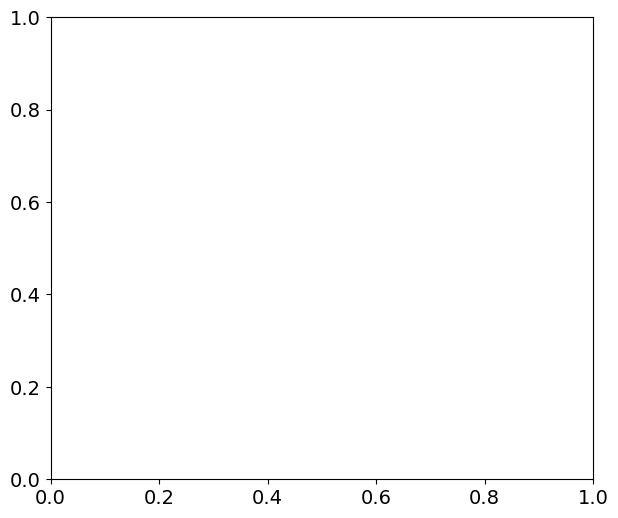

In [42]:
# animation
# Set up Axes with Cartopy Projection
fig, ax = plt.subplots(1,1,figsize=(7,6))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# Initialize frame
# im = ax.tripcolor(iwp.lon.values*180/np.pi, iwp.lat.values*180/np.pi,
#                   np.log10(iwp.isel(time=0).values)+3,
#                  shading='flat')
# cbar = plt.colorbar(im, ax=ax, label="IWP (kg/m$^2$)", shrink=0.3)
plt.show()

# misc

In [4]:
ds = xr.open_dataset(ap.TWP+"CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.1_Subset_20200101-20200331.nc").adj_atmos_lw_up_all_toa_1h
ds.mean().values

array(222.83421, dtype=float32)